### Esempio generico dell'uso di [Map()](https://docs.sunpy.org/en/stable/generated/api/sunpy.map.Map.html), utilizzabile per tutte le immagini con formato fits adeguatamente definito.

Il notebook in ordine deve anche: 
- aprire una pagina web con la visualizzazione di un'immagine di AIA
- scaricare dati di AIA per il giorno dell'eclissi totale di sole del 2024/04/08 (può metterci un po' la prima volta, ma dopo utilizza il file salvato)

Oggetto Map di sunpy è formato da 
- data: np.array
- meta(data): dict (=header di un fits file)

In [12]:
from sunpy.map import Map
import sunpy.data.sample
import os

example_map = Map(sunpy.data.sample.AIA_171_IMAGE)
example_map.quicklook()

print("shape = ", example_map.data.shape)
print("data = ", example_map.data)

shape =  (1024, 1024)
data =  [[ -95.92475      7.076416    -1.9656711 ... -127.96519   -127.96519
  -127.96519  ]
 [ -96.97533     -5.1167884    0.        ...  -98.924576  -104.04137
  -127.919716 ]
 [ -93.99607      1.0189276   -4.0757103 ...   -5.094638   -37.95505
  -127.87541  ]
 ...
 [-128.01454   -128.01454   -128.01454   ... -128.01454   -128.01454
  -128.01454  ]
 [-127.899666  -127.899666  -127.899666  ... -127.899666  -127.899666
  -127.899666 ]
 [-128.03072   -128.03072   -128.03072   ... -128.03072   -128.03072
  -128.03072  ]]


Meta contiene le informazioni sul sistema di riferimento WCS di cui viene tenuto traccia es. per rotazioni.

N.B. sunpy vuole le unità di misura in input per capire come relazionare gli elementi in automatico

<class 'sunpy.util.metadata.MetaDict'>
WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.00089530541880571 0.00038493926472939 
CRPIX : 512.5 512.5 
PC1_1 PC1_2  : 0.99999706448085 0.0024230207763071 
PC2_1 PC2_2  : -0.0024230207763071 0.99999706448085 
CDELT : 0.00066744222222222 0.00066744222222222 
NAXIS : 1024  1024


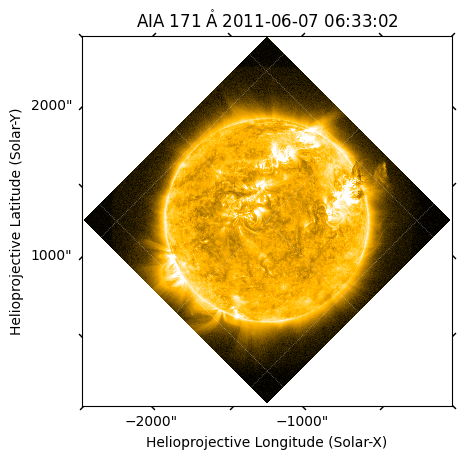

In [13]:
import astropy.units as u

print(type(example_map.meta))
print(example_map.wcs)

example_rotated = example_map.rotate(45 * u.deg)
example_rotated.plot(clip_interval=[1, 99] * u.percent)

## Map per Strato-CorMag. 

Per farlo funzionare su altri strumenti basta cambiare 
- nome del file
- centro del sole nell'immagine (pixel x, pixel y)
- scala (arcsecondi/pixel)

Leggiamo i dati dell'immagine sapendo il nome del file:

In [14]:
from astropy.io import (
    fits,
)  # per leggere i files fits, si può usare anche micropolarray

# ----------------------------------------
# --- METTERE QUI IL PATH ALL'IMMAGINE ---
# ----------------------------------------
# image_filename = "./sample_image_w4096_h3000_t2000_n4_f0_20240408T181639.fits"
image_filename = os.path.join(
    ".", "sample_image_w4096_h3000_t2000_n4_f0_20240408T181639.fits"
)

# with è un context manager, non è necessario ma serve ad ottimizzare l'apertura di files
with fits.open(image_filename) as hdul:
    image_data = hdul[0].data

Vogliamo un header standardizzato. Per far capire a sunpy come è orientata l'immagine dobbiamo dare:
1. centro del sole nel SR scelto (helioprojective=piano di osservazione)
2. centro del sole nell'immagine (coordinate del pixel pixel) 

La prima è un oggetto SkyCoord di astropy in cui definiamo sistema di riferimento helioprojective, centro xy del sole (0,0 perché è l'origine), ora di osservazione e osservatore (terra).

In [15]:
import astropy.units as u  # per dare le unità di misura a sunpy
from datetime import datetime, timezone  # per settare l'ora di osservazione
from astropy.coordinates import SkyCoord  # per impostare il centro del sole
from sunpy.coordinates import Helioprojective  # per il frame di sunpy


observation_time = datetime(
    year=2024, month=4, day=8, hour=18, minute=16, second=39, tzinfo=timezone.utc
)  # 2024-04-18T18:16:39+000

sun_center_coord = SkyCoord(
    Tx=0 * u.arcsec,  # angolo tra piano sole/osservatore e centro del sole
    Ty=0 * u.arcsec,  # angolo tra piano eq. del sole e centro del sole
    frame="helioprojective",
    # unit="pix",
    obstime=observation_time,
    observer="earth",
)

##### N.B. Le prossime due sono le celle da cambiare per gli altri strumenti

Il centro del sole in pixel viene fuori da un algoritmo, qui lo settiamo a mano. Mancano solo la platescale e la rotazione relativa al nord solare (anche questa va calcolata).

In [16]:
sun_center_pixel = (1372, 1422)
rotation_angle = 26.61  # in gradi
platescale = (1, 1)  # in arcosecondi / pixel

Ora mettiamo tutto nella funzione make_fitswcs_header di sunpy per ottenere un header che consente di allineare tutte le immagini.

Aggiungiamo anche qualche informazione descrittiva che può essere utile in futuro.

In [17]:
from sunpy.map.header_helper import make_fitswcs_header

image_header = make_fitswcs_header(
    data=image_data,
    coordinate=sun_center_coord,
    reference_pixel=sun_center_pixel * u.pix,
    scale=platescale * u.arcsec / u.pix,
    rotation_angle=rotation_angle * u.deg,
    telescope="StratoCorMag",
    instrument="PolarCam",
    observatory="Turin Astronomical Observatory",
    exposure=2 * u.s,
    wavelength=530 * u.nm,
)

Ora abbiamo finito: per avere la mappa basta mettere assieme dati ed header, poi plottiamo per vedere il risultato.

La proiezione nel plot serve a dire nel SR di quale mappa vogliamo il plot, poi basta aggiungere su quale axes lo vogliamo. Aggiungiamo il lembo solare per assicurarci che tutto sia stato letto correttamente.

(<matplotlib.patches.Circle at 0x7fddea33d7f0>, None)

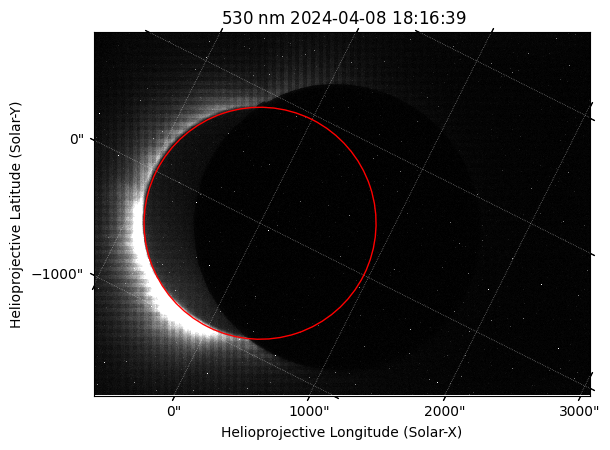

In [18]:
from sunpy import map
import matplotlib.pyplot as plt

cormag_map = map.Map(image_data, image_header)

fig, ax = plt.subplots(subplot_kw=dict(projection=cormag_map))
cormag_map.plot(
    axes=ax, clip_interval=(1, 99) * u.percent
)  # plottiamo i i pixel tra 1 e 99% della luminosità per aumentare il contrasto
cormag_map.draw_limb(axes=ax, color="red")

#### ESEMPI

##### Overplot con immagini di AIA

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_171a_2024_04_08t18_16_45_35z_image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

(<matplotlib.patches.Circle at 0x7fddea953770>, None)

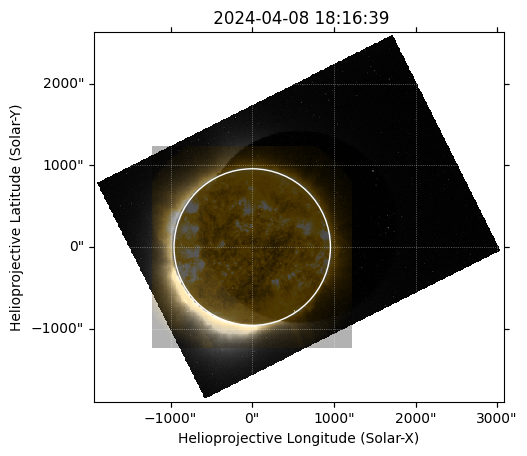

In [19]:
from glob import glob  # per cercare i files
from pathlib import Path
from sunpy.net import Fido, attrs as a  # per scaricare immagini di altri strumenti

# cerca dati locali di AIA, se non li trova usa Fido per cercare dati online e scaricali la prima volta
# aia_files = glob("./AIA/aia*")
aia_path = os.path.join(".", "AIA", "aia*")
aia_files = glob(aia_path)

if not aia_files:
    eclipse_starting_time = datetime(2024, 4, 8, 18, 16, 39, tzinfo=timezone.utc)
    eclipse_ending_time = datetime(2024, 4, 8, 18, 17, 39, tzinfo=timezone.utc)

    result = Fido.search(
        a.Time(eclipse_starting_time, eclipse_ending_time),
        a.Instrument.aia,
        a.Wavelength(171 * u.Angstrom),
        a.Sample(1 * u.min),  # riduce cadenza
    )
    output_path = os.path.join(".", "{instrument}", "{file}")
    Fido.fetch(result, path=output_path)
    # aia_files = glob("./AIA/aia*")
    aia_files = glob(aia_path)

aia_files.sort()


aia_map = map.Map(aia_files[0])  # leggi la prima delle mappe di AIA

# rebinna l'immagine a 200*200 pix per velocizzare
aia_map = aia_map.resample([200, 200] * u.pix)
sampled_cormag = cormag_map.resample([409, 300] * u.pix).rotate()

# caveat: le immagini di AIA vengono da superfice del sole che è 3D, bisogna proiettare su piano di osservazione (=assumere che emissione venga da superficie sferica con osservatore come centro)
with Helioprojective.assume_spherical_screen(sampled_cormag.observer_coordinate):
    aia_map = aia_map.reproject_to(sampled_cormag.wcs)

# plot di cormag, overplot di aia (trasparenza 30%), plot del lembo solare di aia
fig, ax = plt.subplots(subplot_kw=dict(projection=sampled_cormag))
sampled_cormag.plot(axes=ax, clip_interval=(1, 99) * u.percent, autoalign=True)
aia_map.plot(axes=ax, autoalign=True, alpha=0.3, clip_interval=(1, 99) * u.percent)
aia_map.draw_limb()

##### Cut con sunpy (servono le ultime versioni)
È utile fare le analisi in raggi solari, quindi creiamo una nuova unità di misura Rsun e lasciamo le conversioni a sunpy!

Text(0, 0.5, 'Intensity [DN]')

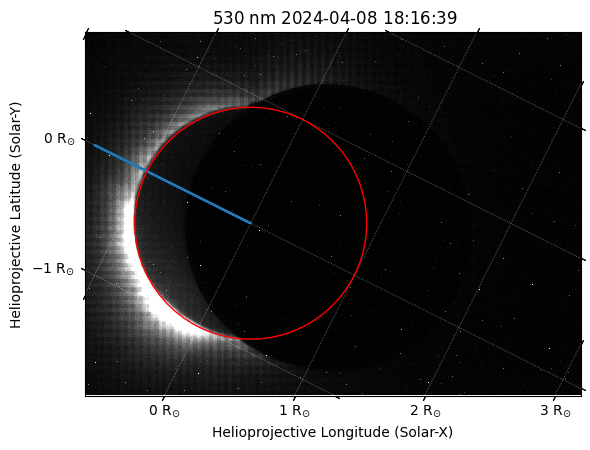

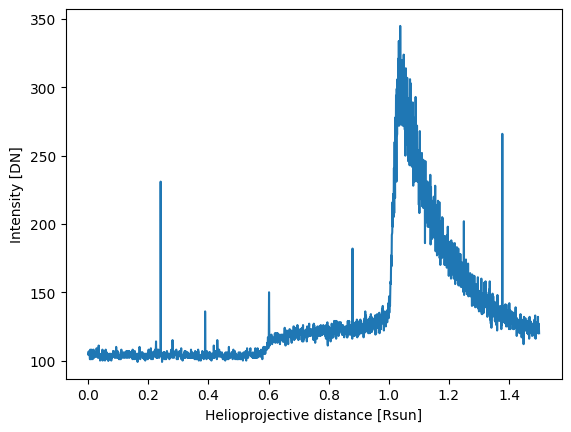

In [20]:
Rsun = u.def_unit(
    r"R$_{\odot}$",
    961 * u.arcsec,  # 1 Rsun = 961 pixel sul sensore
)

# stesso codice di prima
fig, ax = plt.subplots(subplot_kw=dict(projection=cormag_map))
cormag_map.plot(axes=ax, clip_interval=(1, 99) * u.percent)
cormag_map.draw_limb(axes=ax, color="red")

ax.coords[0].set_format_unit(Rsun)
ax.coords[1].set_format_unit(Rsun)

# --- Cut ---
# Vogliamo cut da (0,0) a (0,-1.5) Rsun
line_start_and_end = SkyCoord(
    [0, -1.5],  # coordinate di inizio linea
    [0, 0],  # coordinate della fine della linea
    unit=(Rsun, Rsun),  # unità di misura
    frame=cormag_map.coordinate_frame,
)


intensity_coordinates = map.pixelate_coord_path(
    cormag_map, line_start_and_end
)  # trova le coordinate dei pixels lungo la linea
intensities = map.sample_at_coords(
    cormag_map, intensity_coordinates
)  # trova il valore dei pixel selezionati, sarà la "y".
angular_separation = intensity_coordinates.separation(intensity_coordinates[0]).to(
    Rsun
)  # per ogni punto, calcola la distanza angolare tra lui e l'inizio della linea, e convertila in Rsun. Sarà la "x"

# plot the cut on the image
ax.plot_coord(intensity_coordinates)

fig1, ax1 = plt.subplots()
ax1.plot(angular_separation, intensities, label="Cut")
ax1.set_xlabel("Helioprojective distance [Rsun]")
ax1.set_ylabel("Intensity [DN]")

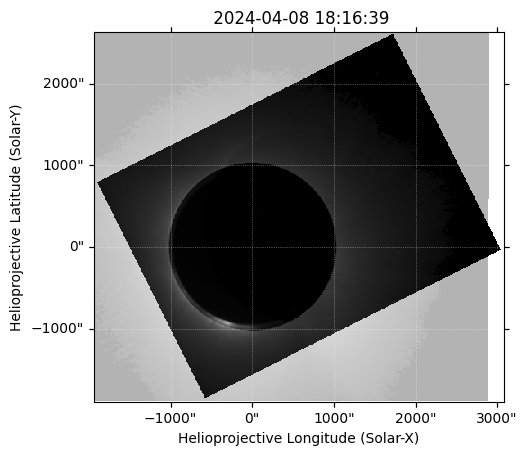

In [21]:
kcor_path = os.path.join("HAO", "pB_2min_avg", "20240409_174852_kcor_l2_avg.fts")
kcor_map = sunpy.map.Map(kcor_path)
kcor_map.resample([200, 200] * u.pix)

with Helioprojective.assume_spherical_screen(sampled_cormag.observer_coordinate):
    kcor_map = kcor_map.reproject_to(sampled_cormag.wcs)

fig, ax = plt.subplots(subplot_kw=dict(projection=kcor_map))
sampled_cormag.plot(axes=ax)
kcor_map.plot(axes=ax, alpha=0.3)

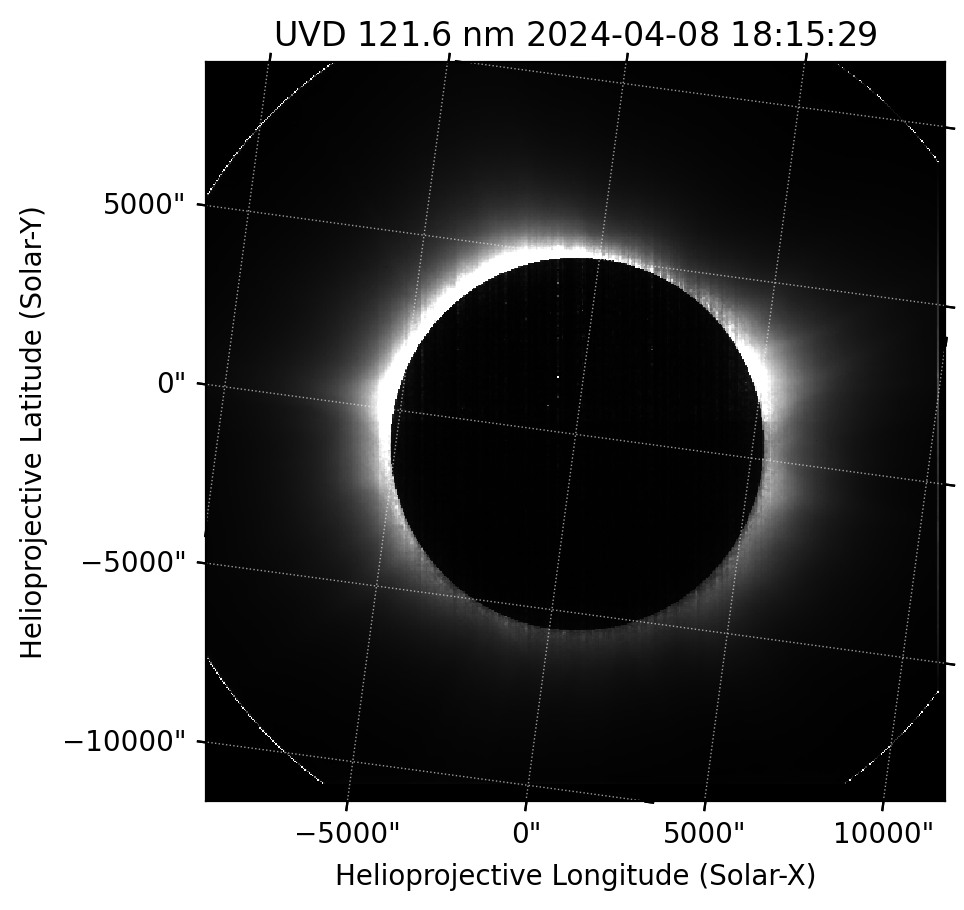

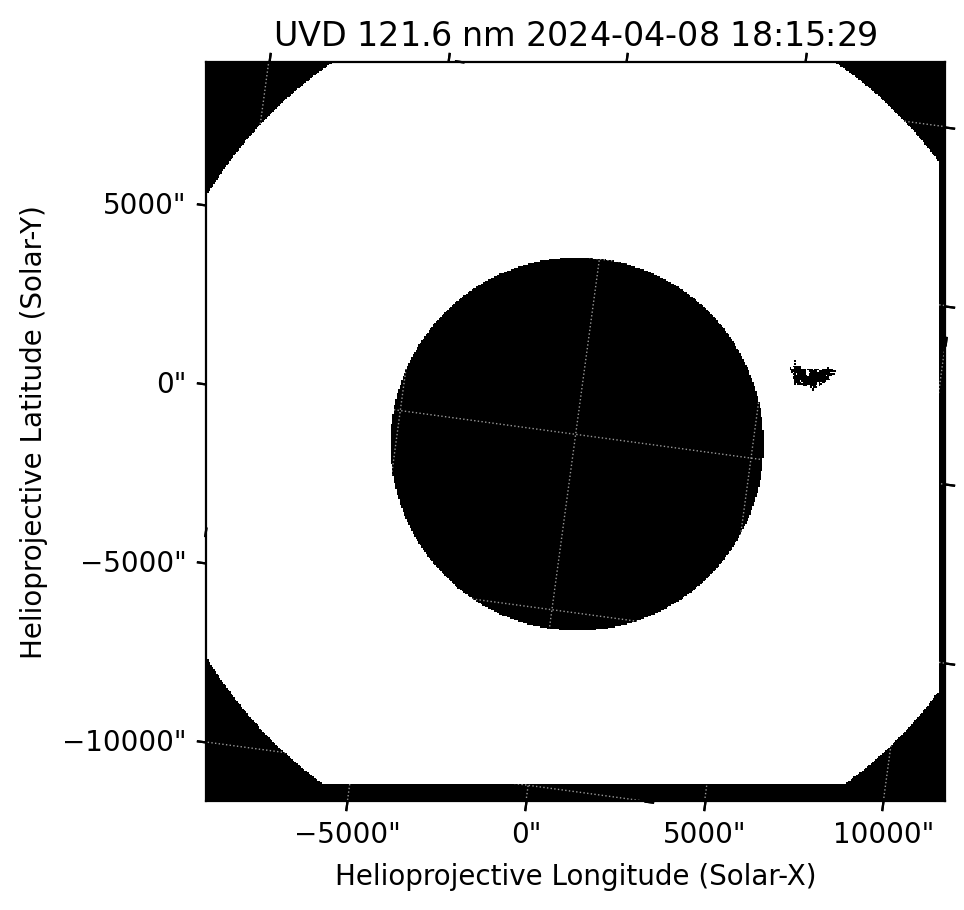

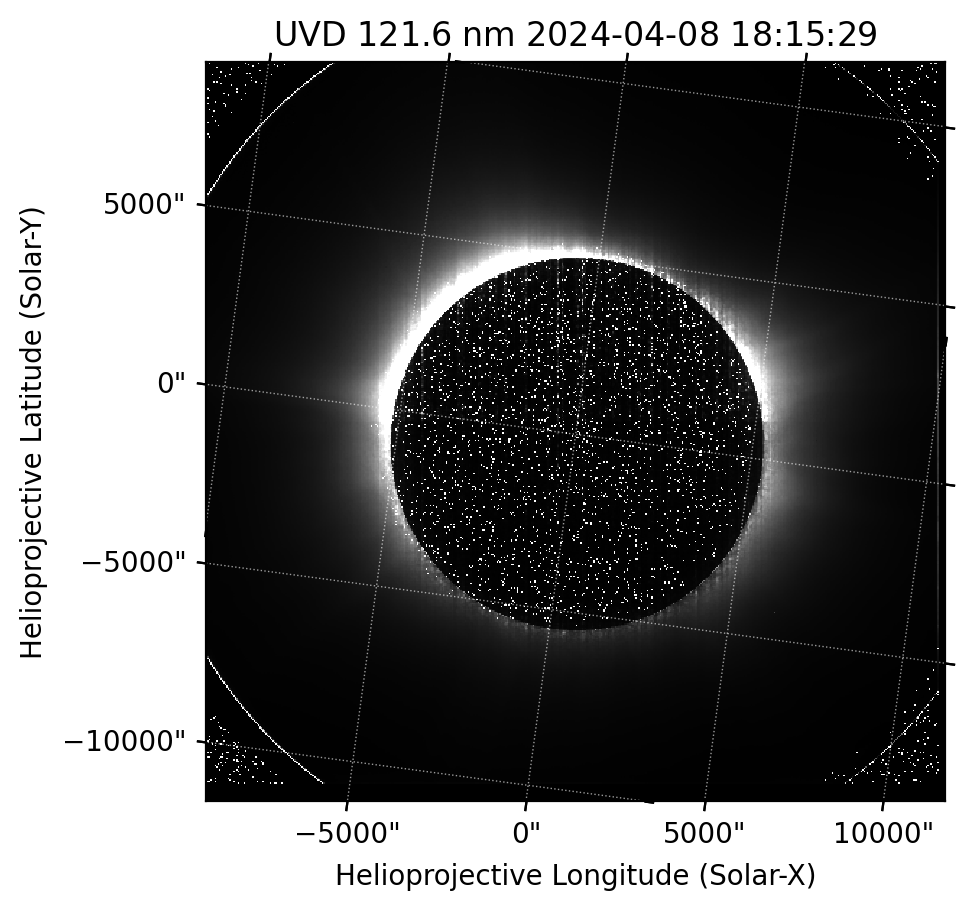

In [22]:
# lasco_map = sunpy.map.Map("LASCO/C2-PB-20240408_1546.fits")

metis_path = os.path.join("METIS", "solo_L2_metis-uv-image_20240408T181529_V01.fits")
metis_map = sunpy.map.Map(metis_path)

fig, ax = plt.subplots(subplot_kw=dict(projection=metis_map[0]), dpi=200)
metis_map[0].plot(axes=ax, clip_interval=(1, 99) * u.percent)
fig, ax = plt.subplots(subplot_kw=dict(projection=metis_map[1]), dpi=200)
metis_map[1].plot(axes=ax, clip_interval=(1, 99) * u.percent)
fig, ax = plt.subplots(subplot_kw=dict(projection=metis_map[2]), dpi=200)
metis_map[2].plot(axes=ax, clip_interval=(1, 99) * u.percent)